# ML Pipeline

## Import

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,TimeSeriesSplit,KFold
from sklearn.dummy import DummyRegressor
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.layers import Input
import h5py
import requests
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
# import XGBoost
from xgboost import XGBRegressor
# import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## Data

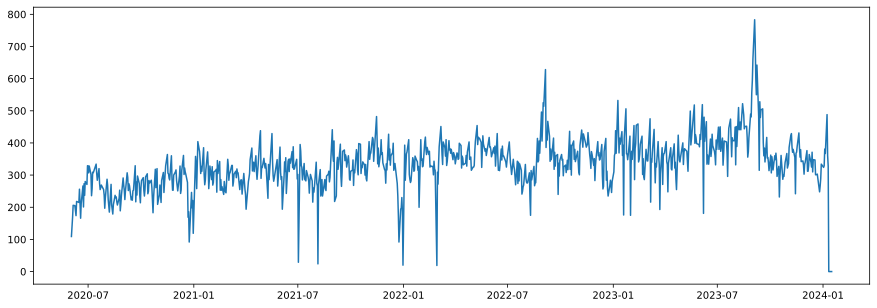

In [80]:
df = pd.read_csv("MontpellierRDVLAG7Event&RDV2018to2024.csv",sep=",",parse_dates=["date"])
df = df[df['RVP'] < 1000]
df = df[df['date'] > "2020-06-01"]
# plot df
plt.figure(figsize=(15,5))
plt.plot(df['date'],df['PT'])

## Create the features

In [81]:
def preprocessor(df):
    df = df.copy()
    df.loc[:, "year"] = df["date"].dt.year
    df.loc[:, 'n_day'] = df['date'].dt.dayofyear
    df.loc[:, 'n_week'] = df['date'].dt.isocalendar().week
    df.loc[:, 'n_month'] = df['date'].dt.month
    df.loc[:, 'n_day_week'] = df['date'].dt.dayofweek
    df.loc[:, 'n_day_month'] = df['date'].dt.day
    
    df = df.drop(columns=["date"])
    df = df.reset_index(drop=True)
    return df

from sklearn.preprocessing import FunctionTransformer
preprocess_transformer = FunctionTransformer(preprocessor)
preprocess_transformer

FunctionTransformer(func=<function preprocessor at 0x000001F45E242430>)

## Create the WeekPipeline

In [82]:
# import sklearn pipeline
from sklearn.pipeline import Pipeline
#  import onehotencoder
from sklearn.preprocessing import OneHotEncoder

# import StandardScaler
from sklearn.preprocessing import StandardScaler

In [83]:
class WeekPipeline():
    def __init__(self, model):
        self.model = Pipeline([
            ('standard', StandardScaler()),
            ('model', model)
        ])
        self.preprocessor = preprocess_transformer
    def split_data(self,df,target_name):
        df = df[df[target_name] > 0].copy()
        df.loc[:, "lag7"] = df[target_name].shift(7)

        # drop na
        df = df.dropna()
        X, y = (df.drop(columns=target_name),df[target_name])
        y = y.reset_index(drop=True)
        return X, y
    def fit_and_predict(self, X_train, y_train, X_test, y_test,isCoef=False):
        coef = []
        X_test = self.preprocessor.transform(X_test)
        X_train = self.preprocessor.transform(X_train)
        y_pred = []
        # Split the data in 7 days groups
        for i in range(0, len(X_test), 7):
            X_week = X_test.iloc[i:i+7]
            y_week = y_test[X_week.index]
            self.model.fit(X_train, y_train)
            if isCoef:
                # We are using a random forest regressor
                coef.append(self.model.named_steps['model'].feature_importances_)
            test_preds = self.model.predict(X_week)
            X_train = pd.concat([X_train, X_week])
            y_train = pd.concat([y_train, y_week])
            y_pred.extend(test_preds)
        return coef,y_pred
    def score(self, y_test,y_pred):
        return np.sqrt(mean_squared_error(y_test, y_pred))
    
    def cross_val_plot(self, X, y, cv=5):
        kf = TimeSeriesSplit(n_splits=cv)
        scores = []
        i = 0
        # Initialise the subplot function using number of rows and columns 
        figure, axis = plt.subplots(cv, 1,figsize=(10, 12)) 
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            # reset index
            X_test = X_test.reset_index(drop=True)
            y_test = y_test.reset_index(drop=True)
            y_pred = self.fit_and_predict(X_train, y_train, X_test, y_test)
            X_period = pd.concat([X_train, X_test])
            y_period = pd.concat([y_train, y_test])
            
            axis[i].plot(X_period['date'],y_period,label='Actual')
            axis[i].plot(X_test['date'],y_pred,label='Predicted')
            # change X scale 
            axis[i].set_xlim(X['date'].min(),X['date'].max())
            i+=1
        plt.show()
    def plot_pred(self,y_test, y_pred):
        # use matplotlib to plot the actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.legend()
        

In [85]:
# convert an array of values into a dataset matrix
def create_dataset_lstm(dataset, look_back=7, forecast_horizon=7):
    dataX, dataY = [], []
    for i in range(0,len(dataset)-look_back-forecast_horizon+1,forecast_horizon):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        b = dataset[(i+look_back):(i+look_back+forecast_horizon), 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [86]:
hyperparameter_grids = {
    'LSTM' : {
        'n_unit_per_layer': [20,30],
        'epochs': [10,15,20,50,100],
    },
    'LinearRegression': {
        'fit_intercept': [True, False],
    },
    'DecisionTreeRegressor': {
        'max_depth': [10, 20,30,40], 
        'min_samples_split': [2, 5, 10], 
    },
    'RandomForestRegressor': {
        'n_estimators': [10, 50, 100], 
        'max_depth': [10, 20],
    },
    'KNeighborsRegressor': {
        'n_neighbors': [10, 15, 20,30],  
        'algorithm': ['auto', 'ball_tree',],
    },
    'DummyRegressor': {
        'strategy': ['mean', 'median'], 
    },
    'SVR': {
        'C': [0.1, 1, 10, 100],  
        'kernel': ['linear', 'rbf'], 
    },
    'AdaBoostRegressor': {
        'n_estimators': [10, 50, 100], 
        'learning_rate': [0.01, 0.1],  
    },
    'BaggingRegressor': {
        'n_estimators': [10, 20, 50], 
        'max_samples': [0.5, 1.0],  
    },
    'ExtraTreesRegressor': {
        'n_estimators': [50, 100],  
        'max_depth': [10, 20, 30],
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100],  
        'learning_rate': [0.01, 0.1, 0.2],  
    },
    "XGBRegressor": {
        'n_estimators': [50, 100],  
        'max_depth': [10, 20, 30],
    },
    "ARIMAX": {
        'order': [(1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2), (3, 1, 1), (3, 1, 2)],
    }
}


In [ ]:
target_name = "PT"

# LSTM model
look_back = 7
forecast_horizon = 7
LSTM_model = Sequential()
ARIMAX = ARIMA(endog=df[target_name])
models = [
    LSTM_model,
    ARIMAX,
    DummyRegressor(),
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_jobs=-1, random_state=42),
    KNeighborsRegressor(n_jobs=-1),
    SVR(),
    AdaBoostRegressor(),
    BaggingRegressor(n_jobs=-1),
    ExtraTreesRegressor(n_jobs=-1),
    GradientBoostingRegressor(),
    XGBRegressor(n_jobs=-1)
]
# Example of integrating GridSearchCV with a specific model in a pipeline
cv = 5
for model in models:
    if model == LSTM_model:
        model_name = "LSTM"
    elif model == ARIMAX:
        model_name = "ARIMAX"
    else:
        model_name = model.__class__.__name__   
    param_grid = hyperparameter_grids[model_name]
    figure, axis = plt.subplots(cv, 1,figsize=(10, 12))
    param_grid = ParameterGrid(param_grid)
    results = []
    plotActual = False
    for param_combination in param_grid:
        # chrono start
        time_start = time.time()
        hyperparameters = param_combination
        value = hyperparameters.get('default')
        if model_name == "LSTM":
            model = Sequential()
            model.add(Input(shape=(1, look_back)))
            model.add(LSTM(hyperparameters.get("n_unit_per_layer")))
            model.add(Dense(forecast_horizon))
            model.compile(loss='mean_squared_error', optimizer='adam')
        elif model_name == "ARIMAX":
            a = 1
        elif value != 'no hyperparameters':
            model.set_params(**hyperparameters)
        pipeline = WeekPipeline(model)
        # print model name
        X,y = pipeline.split_data(df,target_name)
        kf = TimeSeriesSplit(n_splits=cv)
        scores = []
        i = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            # reset index
            X_test = X_test.reset_index(drop=True)
            y_test = y_test.reset_index(drop=True)
            if model_name == "LSTM":
                # scale the data
                scaler = MinMaxScaler(feature_range=(0, 1))
                dataset = y_train.values.reshape(-1, 1)
                dataset = scaler.fit_transform(dataset)
                
                X_train_normalized, y_train = create_dataset_lstm(dataset, look_back, forecast_horizon)
                X_train_normalized = np.array(X_train_normalized).reshape((X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
                model.fit(X_train_normalized, y_train, epochs=hyperparameters.get("epochs"), batch_size=1, verbose=0)
                dataset = y_test.values.reshape(-1, 1)
                dataset = scaler.fit_transform(dataset)
                X_test_normalized, y_test = create_dataset_lstm(dataset, look_back, forecast_horizon)
                X_test_normalized = np.array(X_test_normalized).reshape((X_test_normalized.shape[0], 1, X_test_normalized.shape[1]))
                y_pred = model.predict(X_test_normalized)
                y_pred = scaler.inverse_transform(y_pred)
                y_test = scaler.inverse_transform(y_test)
                y_train = scaler.inverse_transform(y_train)
                # flatten the array
                y_pred = y_pred.flatten()
                y_test = y_test.flatten()
                y_train = y_train.flatten()
            elif model_name == "ARIMAX":
                y_pred = []
                for j in range(0, len(X_test), 7):
                    # X week is index of 7 days
                    X_week = X_test.iloc[j:j+7]
                    y_week = y_test[X_week.index]
                    exogTrain = X_train.drop(columns=['date'])
                    exogTrain.index = y_train.index
                    model = ARIMA(y_train, order=hyperparameters.get('order'),exog=exogTrain)
                    model_fit = model.fit()
                    steps = len(X_week)
                    exogPred = X_week.drop(columns=['date'])
                    exogPred.index = y_week.index
                    test_preds = model_fit.forecast(steps=steps,exog=exogPred)
                    X_train = pd.concat([X_train, X_week])
                    y_train = pd.concat([y_train, y_week])
                    y_pred.extend(test_preds)

            else:
                coef,y_pred = pipeline.fit_and_predict(X_train, y_train, X_test, y_test)
            scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
            X_period = pd.concat([X_train, X_test])   
        
            y_train_series = pd.Series(y_train)
            y_test_series = pd.Series(y_test)
            y_period = pd.concat([y_train_series, y_test_series])
            dates = X_period['date'].values[-len(y_period):]
            dates_pred = X_test['date'].values[-len(y_pred):]
            if not plotActual:
                axis[i].plot(dates,y_period,label='Actual')
                
            axis[i].plot(dates_pred,y_pred,label='Predicted with '+str(hyperparameters))
            # change X scale 
            axis[i].set_xlim(dates.min(),X['date'].max())
            axis[i].legend()
            i+=1
        # set title to the figure
        figure.suptitle(model_name)
        results.append((model_name,hyperparameters,scores,np.mean(scores),"Tps:"+str(time.time()-time_start)+"sec"))
        plotActual = True
    results.sort(key=itemgetter(3))
    print(results[0][0],results[0][1],results[0][2],results[0][3],results[0][4])

# print for each model the best hyperparameters and results

plt.show()

In [ ]:
target_name = "PT"
model = RandomForestRegressor(n_jobs=-1, random_state=42,max_depth=20,n_estimators=50)
pipeline = WeekPipeline(model)
# print model name
X,y = pipeline.split_data(df,target_name)
kf = TimeSeriesSplit(n_splits=cv)
model_name = "Random Forest Regressor"
i = 0
results = []
figure, axis = plt.subplots(cv, 1,figsize=(10, 18))
y_preds = []
# New dataframe df2 to store, date, actual and predicted values
df2 = pd.DataFrame(columns=['date','actual_PT','predicted_PT'])
Coef_means = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # reset index
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    coef,y_pred = pipeline.fit_and_predict(X_train, y_train, X_test, y_test,isCoef=True)
    print(coef)
    Coef_means.append(np.mean(coef,axis=0))
    print(Coef_means)
    print("RMSE"+str(i+1)+" = "+str(np.sqrt(mean_squared_error(y_test, y_pred))))
    results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    df2 = pd.concat([df2,pd.DataFrame({'date':X_test['date'],'actual_PT':y_test,'predicted_PT':y_pred})])


    X_period = pd.concat([X_train, X_test])   
    y_train_series = pd.Series(y_train)
    y_test_series = pd.Series(y_test)
    y_period = pd.concat([y_train_series, y_test_series])
    dates = X_period['date'].values[-len(y_period):]
    dates_pred = X_test['date'].values[-len(y_pred):]
    axis[i].plot(dates,y_period,label='Actual')
        
    axis[i].plot(dates_pred,y_pred,label='Predicted with '+str(hyperparameters))
    # change X scale 
    axis[i].set_xlim(dates.min(),X['date'].max())
    # add x and y label
    axis[i].set_xlabel("Date")
    axis[i].set_ylabel("Nombre de Visites")
    axis[i].legend()
    i+=1
# set title to the figure
print("Mean RMSE = "+str(np.mean(results)))
print("Mean Coef = "+str(np.mean(Coef_means,axis=0)))
plt.show()

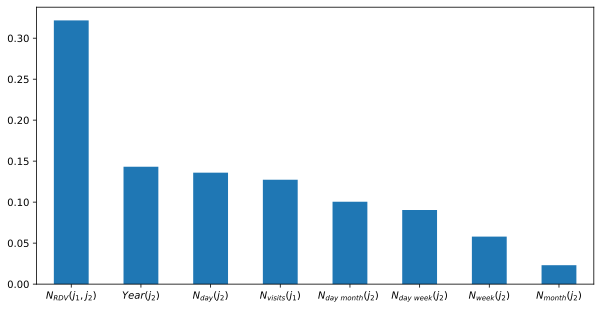

In [103]:
plt.figure(figsize=(10,5))
features_importance = pd.DataFrame(Coef_means,columns=['$N_{RDV}(j_1,j_2)$','$N_{visits}(j_1)$','$Year(j_2)$','$N_{day}(j_2)$','$N_{week}(j_2)$','$N_{month}(j_2)$','$N_{day\ week}(j_2)$','$N_{day\ month}(j_2)$ '])
features_importance = features_importance.mean()
features_importance = features_importance.sort_values(ascending=False)
# put the x value to 45 degree
features_importance.plot(kind='bar')
plt.xticks(rotation=0)
# shift them
# chage fig size

plt.show()

In [47]:
df_new = pd.read_csv('resultMeteo_unique.csv',sep=",",parse_dates=["j2"])
# drop j1 column
df_new = df_new.drop(columns=["j1"])
df_new

,j2,T_min,T_max,daily_weather_description
0,2020-09-09,16.3,27.2,Eclaircies
1,2020-09-10,16.7,26.8,Eclaircies
2,2020-09-11,16.0,25.8,Ensoleillé
3,2020-09-12,17.6,27.0,Averses
4,2020-09-13,16.0,26.1,Averses
...,...,...,...,...
1144,2024-04-12,11.5,26.4,Eclaircies
1145,2024-04-13,11.6,25.0,Eclaircies
1146,2024-04-14,10.2,23.7,Eclaircies
1147,2024-04-15,9.1,22.6,Eclaircies


In [34]:
# Rename the 'j2' column to 'date'
df_new = df_new.rename(columns={"j2": "date"})
# Convert the 'date' column to datetime in both dataframes if not already done
df2['date'] = pd.to_datetime(df2['date'])
df_new['date'] = pd.to_datetime(df_new['date'])

# Merge the dataframes on the 'date' column
merged_df = pd.merge(df2, df_new, on='date')

merged_df

,date,actual_PT,predicted_PT,T_min,T_max,daily_weather_description
0,2021-01-19,302,311.100,5.8,13.0,Rares averses
1,2021-01-20,270,301.740,4.3,12.3,Averses
2,2021-01-21,283,303.660,7.1,13.6,Eclaircies
3,2021-01-22,317,311.000,5.7,12.8,Eclaircies
4,2021-01-25,372,345.480,5.6,12.5,Eclaircies
...,...,...,...,...,...,...
647,2024-01-03,329,376.180,8.2,15.1,Eclaircies
648,2024-01-04,381,378.554,8.1,16.6,Eclaircies
649,2024-01-05,367,362.620,10.0,16.2,Eclaircies
650,2024-01-09,361,377.480,2.9,8.2,Ensoleillé


In [35]:
# Lets transform the daily_weather_description column to numerical values
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
merged_df['daily_weather_description'] = labelencoder.fit_transform(merged_df['daily_weather_description'])
merged_df

,date,actual_PT,predicted_PT,T_min,T_max,daily_weather_description
0,2021-01-19,302,311.100,5.8,13.0,8
1,2021-01-20,270,301.740,4.3,12.3,0
2,2021-01-21,283,303.660,7.1,13.6,3
3,2021-01-22,317,311.000,5.7,12.8,3
4,2021-01-25,372,345.480,5.6,12.5,3
...,...,...,...,...,...,...
647,2024-01-03,329,376.180,8.2,15.1,3
648,2024-01-04,381,378.554,8.1,16.6,3
649,2024-01-05,367,362.620,10.0,16.2,3
650,2024-01-09,361,377.480,2.9,8.2,4
